# **TF-IDF + regresion logística**

En esta libreta, se recoge un modelo basando en TF-IDF y regresión logística para la clasificación de noticias como reales o falsas. Este modelo se ha construido y probado usando el dataset "fake and real news" de kaggle ([enlace a los datos](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)).

Este modelo es el primero de tres que se probarán sobre este set de datos, ya que en este tipo de problemas tanto el proceso de preparación de los datos como el modelo de clasificación pueden influir en el resultado.

Esta libreta se ha ejecutado desde Google Colaboratory.

## Indice

* [1. Carga y limpieza de datos](#section1)
* [2. Comprobar si el dataframe está equilibrado](#section2)
* [3. Preparación de datos](#section3)
* [4. Representación de los datos mediante una matriz TF-IDF](#section4)
* [5. Aprendizaje de un modelo de regresión logística](#section5)
* [6. Validación del modelo](#section6)
* [7. Características más relevantes](#section7)
* [8. Crear un modelo con menos características](#section8)
* [9. Conclusiones](#section9)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

sns.set_theme(style="white")

In [ ]:
import datetime

<a id="section1"></a>

## 1. Carga y limpieza de datos

El proceso de carga y limpieza de datos es similar al que se expuso en el análisis exploratorio de datos. Primero, se cargan las noticias reales en el dataframe ***df_true*** y las noticias falsas en el dataframe ***df_fake***. Después, se eliminan los duplicados de ambos dataframe y las filas del datafarme ***df_fake*** para las que la fecha no está bien informada (en este punto, la fecha no es relevante, pero se ha observado que para esas filas el título y el cuerpo de la noticia no están bien informados tampoco al recoger una URL y no un texto como tal). Luego, se añade la columna "class" a cada uno de estos dataframes (class=0 indicará que la noticia es real y class=1 que la noticia es falsa). A continuación, se concatenan los dataframes formando ***df_news***, se crea una columna adicional en este dataframe ("full_text") con la concatenación del título y del cuerpo de la noticia y se seleccionan sólo las columnas con las que se va a trabajar en los siguientes apartados ("full_text" y "class"). Por último, se desordenan los datos ya que originalmente aparecían ordenados por la columna "class" y se muestra su estructura y las primeras filas del dataframe. El resultado es un dataframe con 44679 noticias formado por dos columnas: "full_text" (donde se recoge el texto relativo al título y al cuerpo de la noticia) y "class" (class=0 si la noticia es real y class=1 si la noticia es falsa).

In [ ]:
# conexión con Google Drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# contenido de la carpeta de Google Drive donde tengo los datos de entrada
%ls "/content/drive/My Drive/News"

Fake.csv  True.csv


In [ ]:
# se cargan las noticias reales y falsas en dataframes
df_true = pd.read_csv('/content/drive/My Drive/News/True.csv', sep=',', parse_dates=['date'])
df_fake = pd.read_csv('/content/drive/My Drive/News/Fake.csv', sep=',', parse_dates=['date'])

In [ ]:
# se eliminan los duplicados
df_true = df_true.drop_duplicates(keep='first')
df_fake = df_fake.drop_duplicates(keep='first')

In [ ]:
# se eliminan las filas para las que la fecha no aparece bien informada
df_fake['date'] = pd.to_datetime(df_fake['date'], errors='coerce')
df_fake = df_fake.dropna(subset=['date'])

In [ ]:
# se añade una columna adicional a cada dataframe indicanco la clase de la noticia
df_true['class'] = 0
df_fake['class'] = 1

In [ ]:
# se concatenan los dataframes
df_news = pd.concat([df_true, df_fake])

In [ ]:
# se crea una columna adicional con el texto que se va a utilizar en próximos apartados (título + cuerpo de la noticia)
df_news['full_text'] = df_news['title'] + ' ' + df_news['text']

In [ ]:
# se filtran las columnas relevantes del dataframe
df_news = df_news[['full_text', 'class']]

In [ ]:
# se desordenan los datos
df_news = df_news.sample(frac=1, random_state=0)

In [ ]:
# se muestra la información del dataframe y sus primeras filas
df_news.info()
df_news.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44679 entries, 7627 to 2743
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  44679 non-null  object
 1   class      44679 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


,full_text,class
7627,Scooby Doo’s ‘Mystery Machine’ Involved In Cr...,1
4826,Trump Campaign Manager And CEO Outed As Membe...,1
14254,SHERIFF CLARKE HAMMERS HOME THE TRUTH: Protest...,1
9286,WEEK #13 of NFL HELL CONTINUES: “Lots of Empty...,1
14226,So Much For Brussels Terror Victims…Let’s Play...,1


<a id="section2"></a>

# 2. Comprobar si el dataframe está equilibrado

Se crea un gráfico de sectores para analizar de forma visual si el dataframe ***df_news*** está equilibrado según la clase. En vista de este gráfico, se comprueba que los datos están bastante balanceados, lo que es importante a la hora de entrenar un modelo de clasificación.

In [ ]:
dict_class_as_text = {0: 'Reales', 1: 'Falsas'}

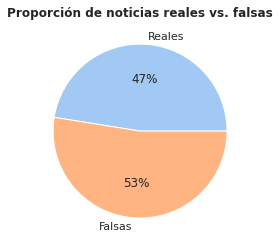

In [ ]:
df_news_pie = df_news.groupby(by='class')['full_text'].count().reset_index().rename(columns={'full_text': 'num_news'})
df_news_pie['class'] = df_news_pie['class'].apply(lambda x: dict_class_as_text[x])

plt.figure(figsize = (4, 4))

colors = sns.color_palette('pastel')[0:2]

plt.pie(df_news_pie['num_news'], labels = df_news_pie['class'], colors = colors, autopct='%.0f%%')
plt.title("Proporción de noticias reales vs. falsas", {"fontsize": 12, 'fontweight': 'bold'});
plt.show()

<a id="section3"></a>

# 3. Preparación de datos

Se crea una función que elimina las etiquetas HTML de un texto.

In [ ]:
def removeHTML(text):
    # se sustituyen las etiquetas HTML por un espacio
    text = re.sub('<[^>]*>', ' ', text)

    return text

Se crea una función para limpiar un texto, convirtiendo el texto en minúsculas y borrando aquellos caracteres que no son alfabéticos.

In [ ]:
def clean(text):
    # se transforma todo el texto a minúsculas
    text = text.lower()
    # se sustituyen los grupos de caracteres que no contienen letras o números (como, por ejemplo, signos de puntuación o símbolos de moneda) por un espacio
    text = re.sub('[\W]+', ' ', text)
    # se sustituyen los números (como, por ejemplo, años o cantidades económicas) que aparezcan en el texto por un espacio
    text = re.sub('[\d]+', ' ', text)

    return text

Se almacenan las stopwords (o palabras sin significado como artículos, preposiciones, etc.) en inglés para luego utilizarlas. Además, se crea el lemitizador que tranformará una forma flexionada de una palabra (por ejemplo, una forma en plural o en femenino) en la forma (o lema) que se acepta como representante de esa palabra por convenio.

In [ ]:
# Este bloque comentado sólo es necesario ejecutarlo la primera vez
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stopwords_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Se crear una función para extraer los términos relevantes de un texto.

In [ ]:
def extractTerms(text):
    # se extraen los token del texto
    text = word_tokenize(text)
    # se extrae el listado de palabras que no están incluidas dentro del listado de stopwords
    word_list = [word for word in text if word not in stopwords_en]
    # se realiza el proceso de lematización sobre el listado de palabras anterior
    lemmatized_word_list = [lemmatizer.lemmatize(word) for word in word_list]

    # se devuelve un texto con los elementos de la lista anterior
    return ' '.join(lemmatized_word_list)

Se procesa la columna "full_text" del dataframe ***df_news*** usando las funciones "removeHTML", "clean" y "extractTerms" y se muestra un ejemplo del resultado.

In [ ]:
df_news['full_text'] = df_news['full_text'].apply(removeHTML)
df_news['full_text'] = df_news['full_text'].apply(clean)
df_news['full_text'] = df_news['full_text'].apply(extractTerms)
df_news.head()

,full_text,class
7627,scooby doo mystery machine involved crazy mph ...,1
4826,trump campaign manager ceo outed member secret...,1
14254,sheriff clarke hammer home truth protester tru...,1
9286,week nfl hell continues lot empty seat biggest...,1
14226,much brussels terror victim let play ball hey ...,1


Se crean dos arrays que se utilizarán después (X -> variables independientes por noticia e y -> variable dependiente u objetivo por noticia) y se muestra un ejemplo de su contenido.

In [ ]:
X = df_news['full_text'].values
print("X - ejemplo contenido: ", X[0:2])

y = df_news['class'].values
print("y - ejemplo contenido: ", y[0:2])

X - ejemplo contenido:  ['scooby doo mystery machine involved crazy mph getaway file one wtf woman driving van painted match mystery machine van scooby doo cartoon decided solving crime square led police high speed chase california florida would normally expect imagine bystander saw well done replica even funky hubcap flash cop car pursuit wondered someone making movie redding com report shasta county probation department official contacted redding police department subject violating probation sometime around p sunday woman identified sharon kay turman redding sgt ron icely said news release officer spotted turman chrysler town country minivan california shasta street fled south vehicle officer tried pull said icely amazingly year old minivan got speed mile per hour pursuit even amazingly despite zero concern safety anyone else road turman managed kill anyone although blow intersection almost hit four car process police called pursuit presumably allow turman stop fleeing blind panic av

<a id="section4"></a>

## 4. Representación de los datos mediante una matriz TF-IDF

Se crea la matriz TF-IDF a partir de X usando el transformador TfidfVectorizer y se muestra un ejemplo del resultado para el primer documento.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,1))
tfidf_vect.fit(X)
X_tfidf = tfidf_vect.transform(X)
print("TF-IDF de X: ", X_tfidf[0:1])

TF-IDF de X:    (0, 106983)	0.035079812875725126
  (0, 105723)	0.01297318681181994
  (0, 104639)	0.05527977781193902
  (0, 104377)	0.011891316588334186
  (0, 104166)	0.04667840769557566
  (0, 104143)	0.06366287698788747
  (0, 103889)	0.03425871928980401
  (0, 103534)	0.03104795665838831
  (0, 103094)	0.1011281451053984
  (0, 102864)	0.029123650921443367
  (0, 102746)	0.01822152063901601
  (0, 102018)	0.026302256606396124
  (0, 101736)	0.04879332339582702
  (0, 100957)	0.030119403668810767
  (0, 100948)	0.03934050907201463
  (0, 100641)	0.01662248025119194
  (0, 100301)	0.13256429223123706
  (0, 99993)	0.08174325179911016
  (0, 98649)	0.04005673354385157
  (0, 97023)	0.01995549560850346
  (0, 96805)	0.07830523560876419
  (0, 96804)	0.46983141365258513
  (0, 95946)	0.02676172582801847
  (0, 95297)	0.02931629402849198
  (0, 95284)	0.028281578556061785
  :	:
  (0, 18146)	0.023965424282903002
  (0, 17636)	0.022518336418391245
  (0, 16721)	0.0221631930229861
  (0, 16138)	0.054124345802368745

La matriz TF-IDF está compuesta por 44679 filas (o documentos) y por 107695 columnas (o palabras/variables independientes), mientras que la variable objetivo está compuesta por 44679 valores. El tamaño del vocabulario coincide con el número de columnas de X.

In [ ]:
print("La matriz TF-IDF tiene la siguiente dimensión: ", X_tfidf.shape)
print("La variable objetivo tiene la siguiente dimensión: ", y.shape)
print("El tamaño del vocabulario es: ", len(tfidf_vect.vocabulary_))

La matriz TF-IDF tiene la siguiente dimensión:  (44679, 107695)
La variable objetivo tiene la siguiente dimensión:  (44679,)
El tamaño del vocabulario es:  107695


<a id="section5"></a>

## 5. Aprendizaje de un modelo de regresión logística

En este punto, se utilizará un modelo de regresión logística binaria para detectar si una noticia es real o falsa (variable dependiente) a partir del vocabulario que presenta esa noticia (variables independientes).

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model

LogisticRegression()

Este modelo posee un único parámetro C (inversa de la regularización, lambda) para el que probaremos 11 valores comprendidos entre $10^{-5}$ y $10^{5}$.

In [ ]:
params = {"C": np.logspace(-5, 5, 11)}
params

{'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
        1.e+03, 1.e+04, 1.e+05])}

Los datos originales (X_tfidf, y -> 100% de los datos originales) se van a separar en dos conjuntos: datos que utilizaremos para entranar el modelo (X_train_val, y_train_val -> 75% de los datos originales) y datos que utilizaremos para calcular su rendimiento (X_test, y_test -> 25% de los datos originales).

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=0)

print("La matriz TF-IDF para los datos de entrenamiento tiene la siguiente dimensión: ", X_train_val.shape)
print("La variable objetivo para los datos de entrenamiento tiene la siguiente dimensión: ", y_train_val.shape)

print("La matriz TF-IDF para los datos de test tiene la siguiente dimensión: ", X_test.shape)
print("La variable objetivo para los datos de test tiene la siguiente dimensión: ", y_test.shape)

La matriz TF-IDF para los datos de entrenamiento tiene la siguiente dimensión:  (33509, 107695)
La variable objetivo para los datos de entrenamiento tiene la siguiente dimensión:  (33509,)
La matriz TF-IDF para los datos de test tiene la siguiente dimensión:  (11170, 107695)
La variable objetivo para los datos de test tiene la siguiente dimensión:  (11170,)


(X_train_val, y_train_val) se han utilizado para entrenar 11 modelos de regresión logística (uno por cada uno de los valores del parámetro C definidos anteriormente) usando validación cruzada de 5 iteraciones (o 5-fold), seleccionando finalmente aquel que proporciona la mejor tasa de acierto.

In [ ]:
from sklearn.model_selection import GridSearchCV

import warnings

with warnings.catch_warnings(record=True):

    print("Inicio selección de modelos: ", datetime.datetime.now())

    lr_model = GridSearchCV(model,
                            params,
                            cv=5)

    lr_model.fit(X_train_val,y_train_val)

    print("Fin selección de modelos: ", datetime.datetime.now())

    print("Mejor valor de C: ", lr_model.best_params_)
    print("Accuracy: ", lr_model.best_score_)

Inicio selección de modelos:  2023-01-02 06:29:42.288992
Fin selección de modelos:  2023-01-02 06:33:55.714992
Mejor valor de C:  {'C': 10000.0}
Accuracy:  0.9933749783066625


El modelo finalmente seleccionado se muestra a continuación y según el valor indicado arriba, presenta una muy buena tasa de acierto debido al gran número de características tenidas en cuenta (107695).

In [ ]:
lr_model = lr_model.best_estimator_
print(lr_model)

LogisticRegression(C=10000.0)


<a id="section6"></a>

## 6. Validación del modelo

**Curva de aprendizaje**

Dibujamos la curva de aprendizaje y vemos cómo afecta el tamaño del conjunto de datos de entrenamiento y de validación sobre el acierto. Vemos que el acierto obtenido con los datos de entrenamiento es siempre muy bueno y que con los datos de validación es bueno también pero va mejorando según aumenta el volumen de datos disponibles por lo que es de preveer que si tuvieramos más datos el acierto sería algo mejor.

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

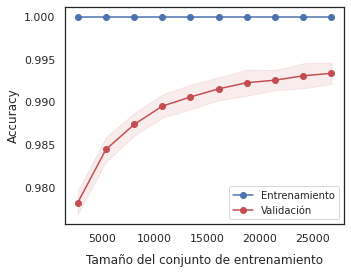

In [ ]:
from sklearn.model_selection import learning_curve

# tamaños del set de entrenamiento
sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# se obtienen los datos de la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(lr_model, X_train_val, y_train_val, cv=5, train_sizes=sizes)

# se calculan las estadísticas para las distintas iteraciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# se dibuja la gráfica
plt.figure(figsize = (5, 4))

plt.xlabel("Tamaño del conjunto de entrenamiento", labelpad=10)
plt.ylabel("Accuracy")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")

plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Validación")
plt.legend(loc=4, fontsize=10)
plt.show()

**Evaluación del modelo**

Se evalúa el modelo de regresión logística calculado previamente con los datos de test y se comprueba que su tasa de acierto es muy buena, incluso un poquito mejor que la obtenida en la fase de entrenamiento (0.9933749783066625). Según se ha comentado antes, esto se debe a que se han tenido en cuenta todas las variables independientes.

In [ ]:
print("La tasa de acierto (con los datos de test) es: ", lr_model.score(X_test,y_test))

La tasa de acierto (con los datos de test) es:  0.9948075201432408


Sacamos la matriz de confusión y vemos que los resultados del modelo son muy buenos ya que casi todos los datos están en la diagonal.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test)

# se obtiene la matriz de confusión
# las filas corresponden con las clases reales y las columnas con las predicciones
cm = confusion_matrix(y_test, y_pred)
print('Matriz de confusión: \n\n', cm, '\n')

Matriz de confusión: 

 [[5316   26]
 [  32 5796]] 



Se obtiene la proporción real de noticias falsas y la proporción de noticias falsas etiquetadas (falsos positivos y verdaderos positivos) y se comprueba que el error entre ambas es mínimo.

In [ ]:
prop_real = np.sum(y_test)/len(y_test)
prop_etiquetadas = (cm[0,1]+cm[1,1])/len(y_test)

print('Proporción real de noticias falsas: %.4f'% prop_real)
print('Proporción de de noticias falsas etiquetadas: %.4f'% prop_etiquetadas)

Proporción real de noticias falsas: 0.5218
Proporción de de noticias falsas etiquetadas: 0.5212


<a id="section7"></a>

## 7. Características más relevantes

Se identifican los 1000 términos más relevantes del vocabulario y se genera un diccionario con las palabras y sus scores.

In [ ]:
# 1000 coeficientes con mayor peso en valor absoluto en la regresión logística
coefficients = lr_model.coef_.ravel()
ord_coefficients = np.argsort(np.abs(coefficients))
best_coefficients = ord_coefficients[-1000:]

# identificación de los términos asociados a esos coeficientes en el vocabulario
terms = np.asarray(tfidf_vect.get_feature_names())
relevant_terms = terms[best_coefficients]
# print(relevant_terms)

# se crea un diccionario con las palabras y sus scores (como enteros)
scores = (np.abs(coefficients[best_coefficients]*100)).astype(np.int)
tag_scores = dict(zip(relevant_terms,scores))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
<ipython-input-33-e1dbec5d9c72>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = (np.abs(coefficients[best_coefficients]*100)).astype(np.int)


Se genera una nube de palabras y se observa que las palabras más relevantes para la clasificación son "reuters", "said", "video", "via", "read" e "image" entre otras. Algunas de las palabras que aparecen en este listado son comunes con las que vimos en el análisis exploratorio de datos, pero otras no.

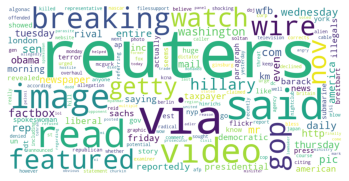

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(max_words= 1000, width = 1000, height = 500,
                      background_color ='white',
                      stopwords = STOPWORDS,
                      min_font_size = 10).generate_from_frequencies(tag_scores)

plt.imshow(wordcloud)
plt.axis("off")
plt.show();

<a id="section8"></a>

## 8. Crear un modelo con menos características

Se crea un modelo con menos características en previsión de que, en futuros pasos de este trabajo, sea complicado crear redes neuronales con el vocabulario completo y por tanto, comparar los resultados del modelo anterior con los de los nuevos modelos a crear. El nuevo vocabulario estará compuesto por los 1000 términos más relevantes que se identificaron en el apartado anterior.

In [ ]:
new_vocabulary = {}
for position, word in enumerate(relevant_terms):
    new_vocabulary[word] = position

Se crea la matriz TD-IDF asociada a estos datos y la extraen las variables (independientes y dependiente) con las que se va a trabajar posteriormente.

In [ ]:
tfidf_vect_short = TfidfVectorizer(ngram_range=(1,1), vocabulary=new_vocabulary)
tfidf_vect_short.fit(X)
X_tdidf_short = tfidf_vect_short.transform(X)
y_short = df_news['class'].values

La matriz TF-IDF está compuesta por 44679 filas (o documentos) y por 1000 columnas (o palabras/variables independientes), mientras que la variable objetivo está compuesta por 44679 valores. El tamaño del vocabulario coincide con el número de columnas de X.

In [ ]:
print("La matriz TF-IDF tiene la siguiente dimensión: ", X_tdidf_short.shape)
print("La variable objetivo tiene la siguiente dimensión: ", y_short.shape)
print("El tamaño del vocabulario es: ", len(tfidf_vect_short.vocabulary_))

La matriz TF-IDF tiene la siguiente dimensión:  (44679, 1000)
La variable objetivo tiene la siguiente dimensión:  (44679,)
El tamaño del vocabulario es:  1000


Los datos de partida se separan en datos de entrenamiento y de validación (75% del total) y en datos de test (25% del total).

In [ ]:
X_train_val_short, X_test_short, y_train_val_short, y_test_short = train_test_split(X_tdidf_short, y_short, test_size=0.25, random_state=0)

print("La matriz TF-IDF para los datos de entrenamiento tiene la siguiente dimensión: ", X_train_val_short.shape)
print("La variable objetivo para los datos de entrenamiento tiene la siguiente dimensión: ", y_train_val_short.shape)

print("La matriz TF-IDF para los datos de test tiene la siguiente dimensión: ", X_test_short.shape)
print("La variable objetivo para los datos de test tiene la siguiente dimensión: ", y_test_short.shape)

La matriz TF-IDF para los datos de entrenamiento tiene la siguiente dimensión:  (33509, 1000)
La variable objetivo para los datos de entrenamiento tiene la siguiente dimensión:  (33509,)
La matriz TF-IDF para los datos de test tiene la siguiente dimensión:  (11170, 1000)
La variable objetivo para los datos de test tiene la siguiente dimensión:  (11170,)


Se entrenan varios modelos y se selecciona el mejor según su tasa de acierto. El valor de C del modelo resultante cambia a 100 y la tasa de acierto para los datos de entrenamiento y validación mejora un poco pasando de 0.9933749783066625 a 0.9968068520530192, siendo en ambos casos muy muy buena.

In [ ]:
with warnings.catch_warnings(record=True):

    print("Inicio selección de modelos: ", datetime.datetime.now())

    lr_model_short = GridSearchCV(model,
                            params,
                            cv=5)

    lr_model_short.fit(X_train_val_short,y_train_val_short)

    print("Fin selección de modelos: ", datetime.datetime.now())

    print("Mejor valor de C: ", lr_model_short.best_params_)
    print("Acierto: ", lr_model_short.best_score_)

Inicio selección de modelos:  2023-01-02 06:42:38.652401
Fin selección de modelos:  2023-01-02 06:43:01.845430
Mejor valor de C:  {'C': 100.0}
Acierto:  0.9968068520530192


Se evalúa el modelo seleccionado previamente usando los datos de test. Al reducirse el número de características la tasa de acierto usando los datos de test casi no cambia, pasando de 0.9949865711727842 a 0.9948075201432408, lo que evidencia que el nuevo modelo sigue siendo muy bueno.

In [ ]:
lr_model_short = lr_model_short.best_estimator_
print("La tasa de acierto (con los datos de test) es: ", lr_model_short.score(X_test_short,y_test_short))

La tasa de acierto (con los datos de test) es:  0.9949865711727842


Según la matriz de confusión, los resultados del nuevo modelo siguen siendo muy buenos ya que casi todos los datos están en la diagonal.

In [ ]:
y_pred_short = lr_model_short.predict(X_test_short)

# se obtiene la matriz de confusión
# las filas corresponden con las clases reales y las columnas con las predicciones
cm_short = confusion_matrix(y_test_short, y_pred_short)
print('Matriz de confusión: \n\n', cm_short, '\n')

Matriz de confusión: 

 [[5315   27]
 [  29 5799]] 



El error entre la proporción real de noticias falsas y la proporción de noticias falsas etiquetadas por el modelo que usa el vocabulario reducido (falsos positivos y verdaderos positivos) es igual que el obtenido para el modelo que usa el vocabulario completo, por lo que parece que trabajar sólo con las 1000 caraceterísticas más relevantes es suficiente.

In [ ]:
prop_real_short = np.sum(y_test_short)/len(y_test_short)
prop_etiquetadas_short = (cm[0,1]+cm[1,1])/len(y_test_short)

print('Proporción real de noticias falsas: %.4f'% prop_real_short)
print('Proporción de de noticias falsas etiquetadas: %.4f'% prop_etiquetadas_short)

Proporción real de noticias falsas: 0.5218
Proporción de de noticias falsas etiquetadas: 0.5212


Los resultados obtenidos con este modelo sencillo son muy buenos y quizás no justifican la creación de modelos más complejos más allá del interés didáctico que esto pueda tener.

<a id="section9"></a>

## 9. Conclusiones

Los resultados obtenidos con este enfoque sencillo donde se trabaja con un número reducido de carcaterísticas (1000) y sin información del contexto son muy buenos y quizás no justifican la creación de modelos más complejos más allá del interés didáctico que esto pueda tener. Esto puede deberse a las deficiencias del dataset identificadas en el análisis exploratorio de los datos y a que el proceso de limpieza de datos quizás no ha sido suficientemente exahustivo. En algunos cuerpos de las noticias aparece su fuente (por ejemplo, reuters) y esto puede introducir sesgo ya todas las noticias de esa fuente siempre son verdaderas o falsas.

Como mejoras futuras, se propone crear un pipeline con los pasos recogidos en apartados anteriores para automatizar el proceso.